In [1]:

import pandas as pd
import numpy as np
import statsmodels.api as sm
import math as m
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import metrics


def read_csv():
    train_df = pd.read_csv('dss-regression-datasets/project-sberbank-housing-market-data/train.csv')
    return train_df


def switch_1_0(train_df):
    for column in train_df.iloc[:, 2:(len(train_df.columns) - 1)]:

        if (len(train_df[column].unique()) == 2):
            if train_df[column].unique()[0] == "yes" or train_df[column].unique()[1] == "yes":
                train_df[column] = train_df[column].replace("yes", 1)
                train_df[column] = train_df[column].replace("no", 0)
            elif train_df[column].unique()[0] == "y" or train_df[column].unique()[1] == "y":
                train_df[column] = train_df[column].replace("y", 1)
                train_df[column] = train_df[column].replace("n", 0)
            else:
                str1 = train_df[column].unique()[0]
                str2 = train_df[column].unique()[1]

                train_df[column] = train_df[column].replace(str1, 1)
                train_df[column] = train_df[column].replace(str2, 0)

    return train_df



def regression_by_2column(train_df):

    ok_col_list = list()

    result_df = pd.DataFrame()
    result_df['const_value'] = None
    result_df['const_pvalue'] = None
    result_df['col_name'] = None
    result_df['col_slope'] = None
    result_df['col_pvalue'] = None

    for column in train_df.iloc[:, 2: len(train_df.columns) - 1]:

        try:
            result_df.loc[len(result_df['col_name']), 'col_name'] = column
            x_train_df = sm.add_constant(train_df[column])  # data_df에 const 추가
            model = sm.OLS(train_df['price_doc'], x_train_df).fit()

            if not (m.isnan(model.pvalues[0])):


                result_df.loc[len(result_df['const_value']) - 1, 'const_value'] = format(model.params[0],'>11.3f')
                result_df.loc[len(result_df['const_pvalue']) - 1, 'const_pvalue'] = format(model.pvalues[0],'>11.3f')
                result_df.loc[len(result_df['col_slope']) - 1, 'col_slope'] = format(model.params[1],'>11.3f')
                result_df.loc[len(result_df['col_pvalue']) - 1, 'col_pvalue'] = format(model.pvalues[1],'>11.3f')
                ok_col_list.append(column)
            else:
                result_df.loc[len(result_df['col_slope']) - 1, 'col_slope'] = ""
                result_df.loc[len(result_df['col_pvalue']) - 1, 'col_pvalue'] = -1

        except:
            result_df.loc[len(result_df['col_slope']) - 1, 'col_slope'] = ""
            result_df.loc[len(result_df['col_pvalue']) - 1, 'col_pvalue'] = -1

    return result_df, ok_col_list


def backward_elim_reg(train_df, ok_col_list):

    result_df2 = pd.DataFrame()

    try_x_train_df = train_df[ok_col_list]

    num_high_pvalue = 1000

    while num_high_pvalue > 0:

        try_x_train_df = sm.add_constant(try_x_train_df)
        model = sm.OLS(train_df['price_doc'], try_x_train_df).fit()

        sorted_pvalues = model.pvalues.sort_values(ascending=False)
        if sorted_pvalues.index[0] == 'const':
            try_x_train_df = try_x_train_df.drop(sorted_pvalues.index[1], 1)
        else:
            try_x_train_df = try_x_train_df.drop(sorted_pvalues.index[0], 1)


        num_high_pvalue = len(model.pvalues[model.pvalues >= 0.05])

    model = sm.OLS(train_df['price_doc'], try_x_train_df).fit()

    result_df2['col_name'] = model.pvalues.index.values
    result_df2['col_slope'] = model.params.values
    result_df2['col_pvalue'] = model.pvalues.values
    result_df2['col_std_error'] = model.bse.values


    return result_df2, model, train_df['price_doc'], try_x_train_df


def del_row_missing(train_df):
    train_df = train_df[train_df.notnull().all(axis=1)]
    return train_df

train_df = read_csv()
switch_df = switch_1_0(train_df)



complete_df = del_row_missing(switch_df)



result_df, ok_col_list = regression_by_2column(complete_df)


result_df, model, y_true, final_const_x_df = backward_elim_reg(complete_df, ok_col_list)

y_predict = model.predict(final_const_x_df)
print('RMSE: ', np.sqrt(metrics.mean_squared_error(y_true, y_predict)))
print('R2 : ', model.rsquared, '\n')
print('Adj. R2 : ', model.rsquared_adj, '\n')
print(ok_col_list.head())


/home/dockeruser/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:1036: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
/home/dockeruser/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/home/dockeruser/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/home/dockeruser/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


RMSE:  3900863.69204
R2 :  0.617158248465 

Adj. R2 :  0.612316775587 



AttributeError: 'list' object has no attribute 'head'

In [3]:
len(ok_col_list)

287

In [3]:
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:              price_doc   R-squared:                       0.617
Model:                            OLS   Adj. R-squared:                  0.612
Method:                 Least Squares   F-statistic:                     127.5
Date:                Thu, 19 Oct 2017   Prob (F-statistic):               0.00
Time:                        18:54:44   Log-Likelihood:                -70449.
No. Observations:                4245   AIC:                         1.410e+05
Df Residuals:                    4191   BIC:                         1.413e+05
Df Model:                          53                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

In [8]:
model.params.index

Index(['const', 'full_sq', 'life_sq', 'floor', 'build_year', 'kitch_sq',
       'state', 'product_type', 'green_zone_part', 'children_school',
       'school_education_centers_raion', 'hospital_beds_raion',
       'thermal_power_plant_raion', 'ekder_all', '7_14_all', '7_14_male',
       '7_14_female', '0_13_female', 'build_count_monolith',
       'build_count_after_1995', 'metro_min_avto', 'industrial_km',
       'water_treatment_km', 'railroad_station_avto_min', 'mkad_km',
       'sadovoe_km', 'bulvar_ring_km', 'ID_big_road1', 'railroad_1line',
       'zd_vokzaly_avto_km', 'bus_terminal_avto_km', 'radiation_km',
       'power_transmission_line_km', 'thermal_power_plant_km',
       'cafe_sum_500_min_price_avg', 'cafe_sum_500_max_price_avg',
       'cafe_avg_price_500', 'cafe_count_500_price_1500', 'leisure_count_500',
       'cafe_avg_price_1000', 'cafe_count_1000_price_1000',
       'cafe_count_1000_price_1500', 'office_sqm_1500', 'cafe_count_1500',
       'cafe_count_1500_price_1500'

In [9]:

complete_df[['full_sq', 'life_sq', 'floor', 'build_year', 'kitch_sq',
       'state', 'product_type', 'green_zone_part', 'children_school',
       'school_education_centers_raion', 'hospital_beds_raion',
       'thermal_power_plant_raion', 'ekder_all', '7_14_all', '7_14_male',
       '7_14_female', '0_13_female', 'build_count_monolith',
       'build_count_after_1995', 'metro_min_avto', 'industrial_km',
       'water_treatment_km', 'railroad_station_avto_min', 'mkad_km',
       'sadovoe_km', 'bulvar_ring_km', 'ID_big_road1', 'railroad_1line',
       'zd_vokzaly_avto_km', 'bus_terminal_avto_km', 'radiation_km',
       'power_transmission_line_km', 'thermal_power_plant_km',
       'cafe_sum_500_min_price_avg', 'cafe_sum_500_max_price_avg',
       'cafe_avg_price_500', 'cafe_count_500_price_1500', 'leisure_count_500',
       'cafe_avg_price_1000', 'cafe_count_1000_price_1000',
       'cafe_count_1000_price_1500', 'office_sqm_1500', 'cafe_count_1500',
       'cafe_count_1500_price_1500', 'cafe_count_1500_price_2500',
       'cafe_count_1500_price_4000', 'cafe_count_1500_price_high',
       'big_church_count_1500', 'leisure_count_1500',
       'cafe_count_2000_price_high', 'leisure_count_2000', 'prom_part_3000',
       'office_count_3000', 'big_church_count_3000',
       'cafe_count_5000_price_4000']].corr()

,full_sq,life_sq,floor,build_year,kitch_sq,state,product_type,green_zone_part,children_school,school_education_centers_raion,...,cafe_count_1500_price_4000,cafe_count_1500_price_high,big_church_count_1500,leisure_count_1500,cafe_count_2000_price_high,leisure_count_2000,prom_part_3000,office_count_3000,big_church_count_3000,cafe_count_5000_price_4000
full_sq,1.000000,0.824128,0.210539,-0.010843,0.402380,-0.056862,-0.181191,-0.008330,-0.040063,0.025387,...,0.112199,0.141910,0.111749,0.144341,0.153462,0.123229,-0.104978,0.147877,0.132609,0.165265
life_sq,0.824128,1.000000,0.123823,-0.013740,0.220756,-0.105445,-0.279716,0.008405,-0.030412,0.008881,...,0.166429,0.177654,0.161019,0.175963,0.195915,0.169409,-0.103700,0.181075,0.166126,0.193332
floor,0.210539,0.123823,1.000000,0.004725,0.225613,-0.013767,-0.143400,0.055733,-0.004531,-0.038283,...,0.021742,-0.005383,0.035955,0.002145,0.013685,0.015835,-0.036607,-0.005359,0.004846,-0.005896
build_year,-0.010843,-0.013740,0.004725,1.000000,0.006194,0.562835,0.003916,-0.011024,-0.000680,-0.004155,...,-0.004916,-0.004772,-0.007023,-0.002710,-0.005149,-0.002652,-0.008952,-0.003033,-0.005749,-0.005745
kitch_sq,0.402380,0.220756,0.225613,0.006194,1.000000,0.120359,0.201477,-0.000204,0.000652,0.040715,...,-0.132055,-0.074635,-0.131168,-0.082230,-0.091007,-0.118578,0.008555,-0.088639,-0.091581,-0.055074
state,-0.056862,-0.105445,-0.013767,0.562835,0.120359,1.000000,0.368442,0.006366,0.012757,0.038725,...,-0.185052,-0.128410,-0.188078,-0.133953,-0.154366,-0.166223,0.022650,-0.141608,-0.141683,-0.118574
product_type,-0.181191,-0.279716,-0.143400,0.003916,0.201477,0.368442,1.000000,-0.004104,0.070920,0.094608,...,-0.478179,-0.350750,-0.481866,-0.349962,-0.413828,-0.432221,0.114333,-0.375503,-0.374247,-0.326515
green_zone_part,-0.008330,0.008405,0.055733,-0.011024,-0.000204,0.006366,-0.004104,1.000000,0.203815,0.135903,...,-0.164970,-0.189913,-0.182855,-0.164776,-0.186991,-0.170503,-0.213161,-0.283204,-0.238103,-0.256923
children_school,-0.040063,-0.030412,-0.004531,-0.000680,0.000652,0.012757,0.070920,0.203815,1.000000,0.506116,...,-0.041390,-0.063751,-0.069387,-0.049026,-0.067246,-0.055659,-0.149052,-0.164872,-0.120481,-0.153909
school_education_centers_raion,0.025387,0.008881,-0.038283,-0.004155,0.040715,0.038725,0.094608,0.135903,0.506116,1.000000,...,-0.063572,-0.033767,-0.069328,-0.046585,-0.048948,-0.069700,-0.086697,-0.071456,-0.042219,-0.022758


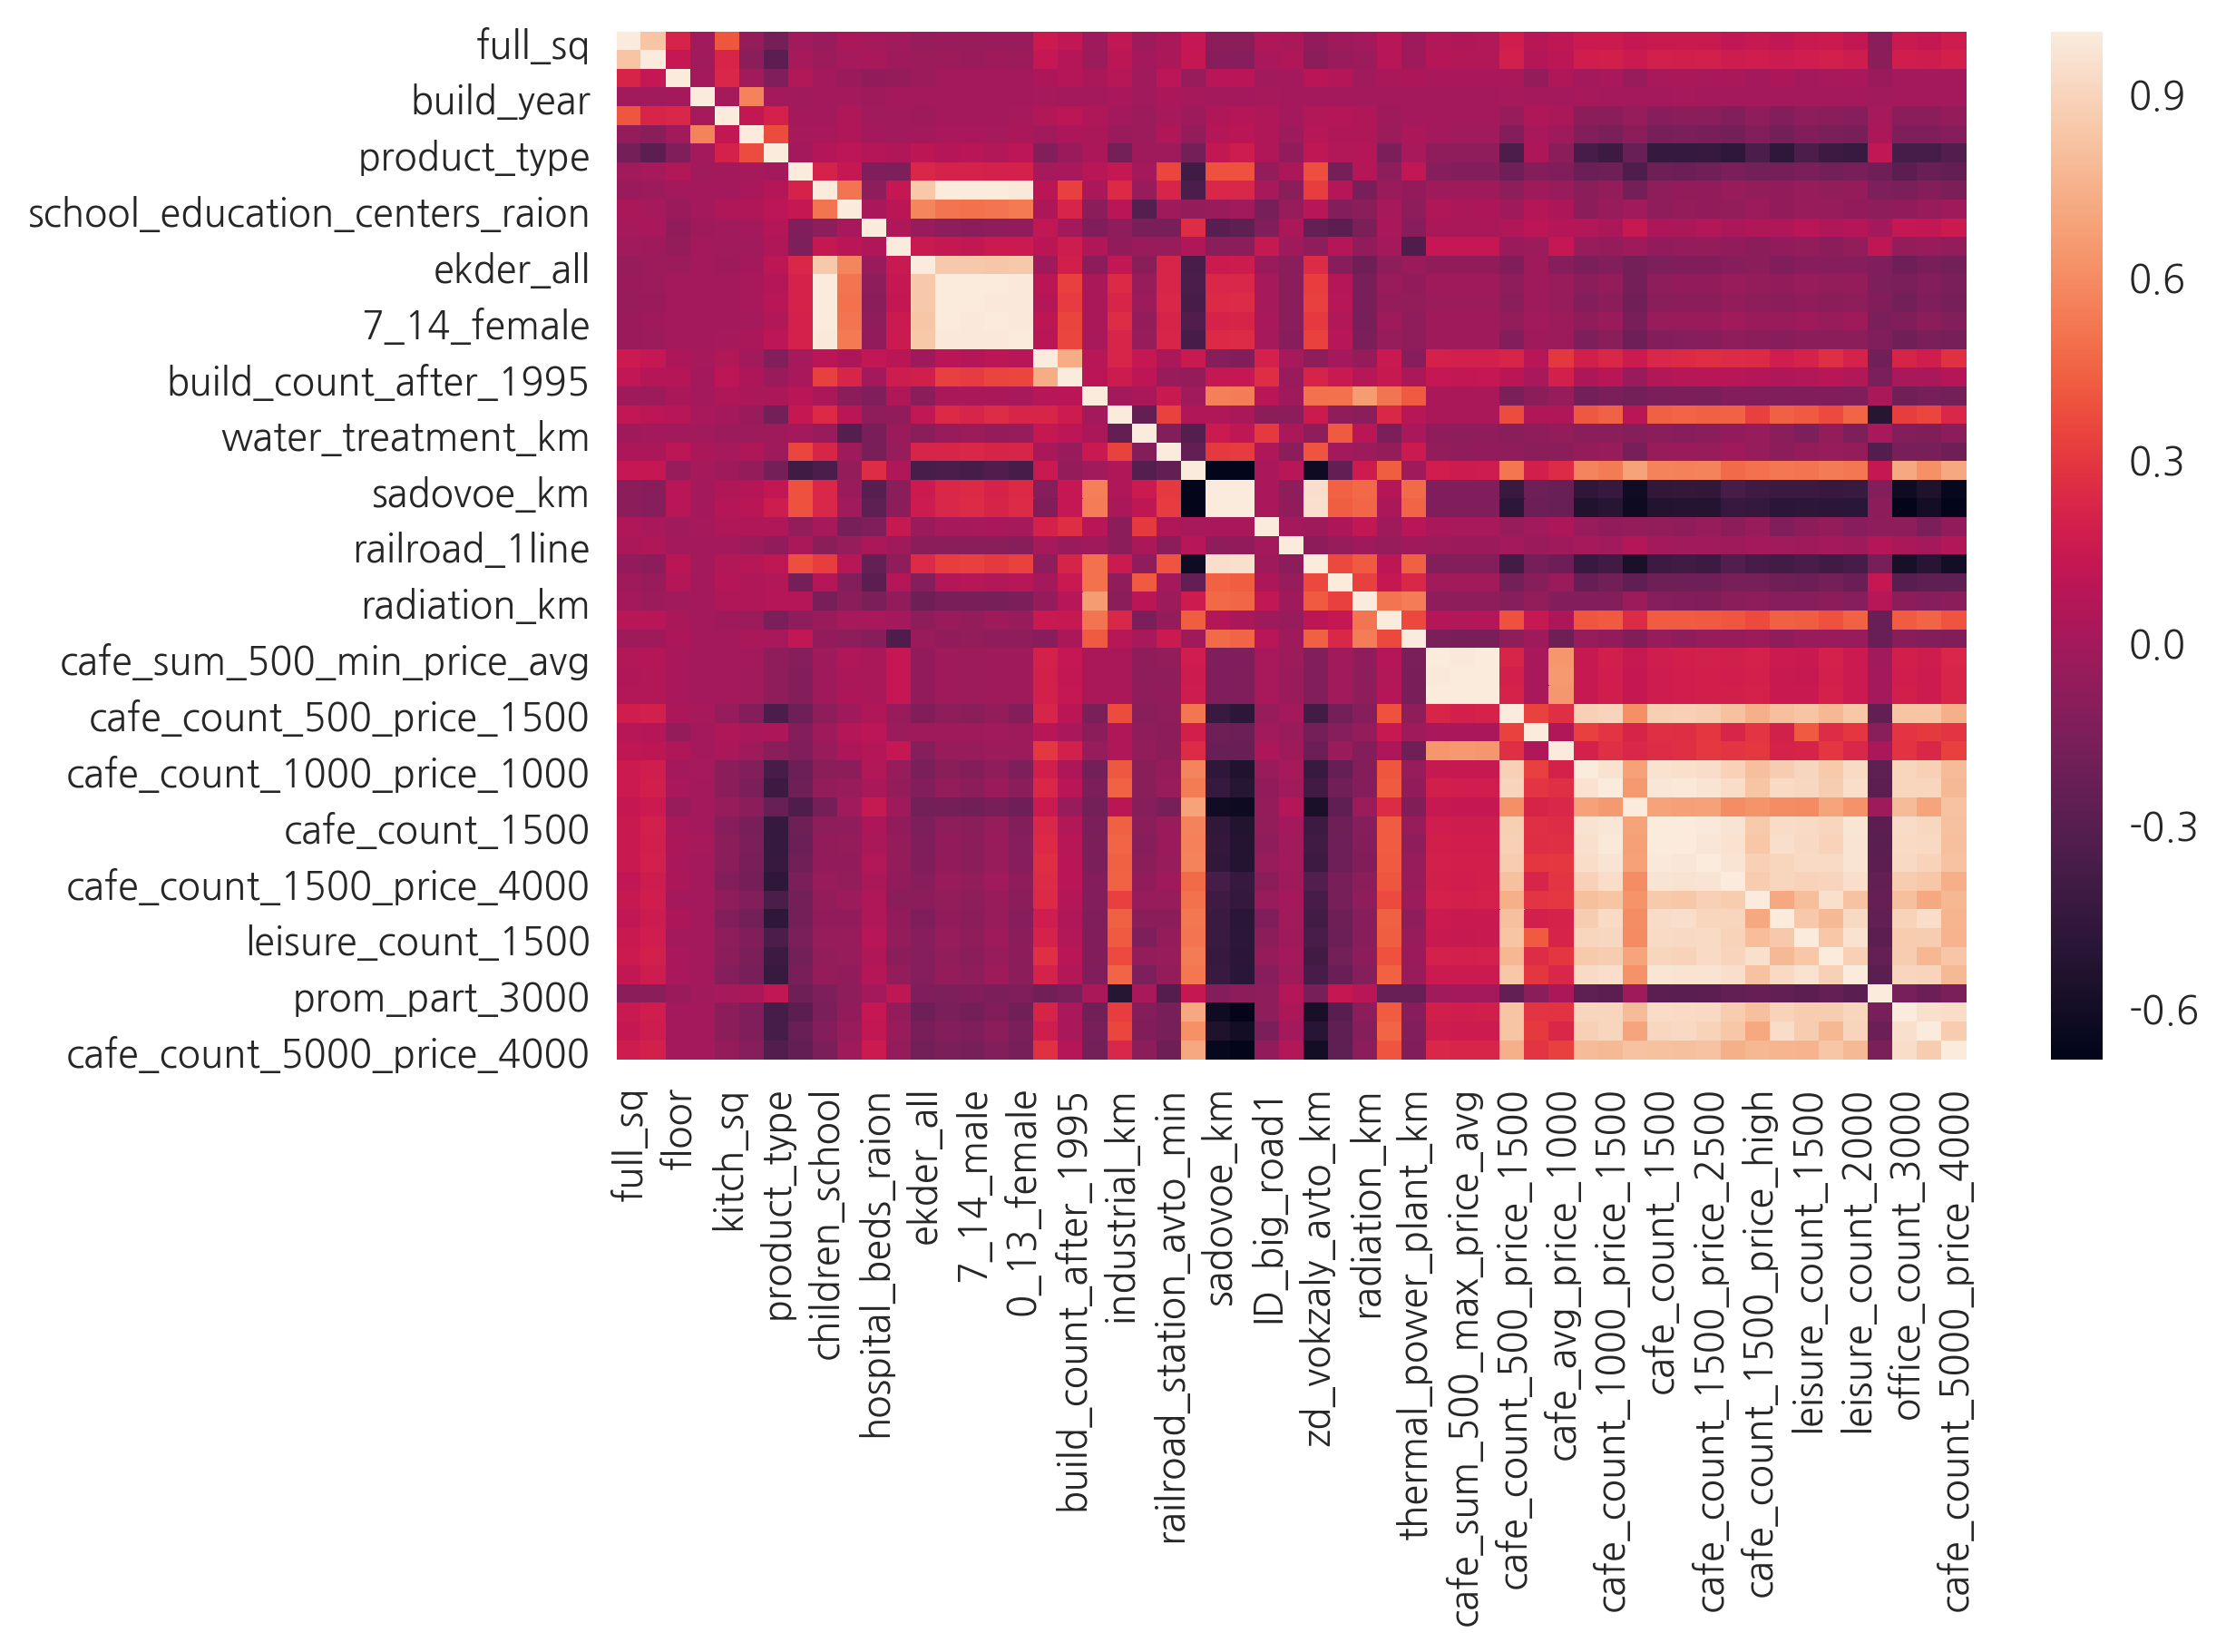

In [10]:
sns.heatmap(complete_df[['full_sq', 'life_sq', 'floor', 'build_year', 'kitch_sq',
       'state', 'product_type', 'green_zone_part', 'children_school',
       'school_education_centers_raion', 'hospital_beds_raion',
       'thermal_power_plant_raion', 'ekder_all', '7_14_all', '7_14_male',
       '7_14_female', '0_13_female', 'build_count_monolith',
       'build_count_after_1995', 'metro_min_avto', 'industrial_km',
       'water_treatment_km', 'railroad_station_avto_min', 'mkad_km',
       'sadovoe_km', 'bulvar_ring_km', 'ID_big_road1', 'railroad_1line',
       'zd_vokzaly_avto_km', 'bus_terminal_avto_km', 'radiation_km',
       'power_transmission_line_km', 'thermal_power_plant_km',
       'cafe_sum_500_min_price_avg', 'cafe_sum_500_max_price_avg',
       'cafe_avg_price_500', 'cafe_count_500_price_1500', 'leisure_count_500',
       'cafe_avg_price_1000', 'cafe_count_1000_price_1000',
       'cafe_count_1000_price_1500', 'office_sqm_1500', 'cafe_count_1500',
       'cafe_count_1500_price_1500', 'cafe_count_1500_price_2500',
       'cafe_count_1500_price_4000', 'cafe_count_1500_price_high',
       'big_church_count_1500', 'leisure_count_1500',
       'cafe_count_2000_price_high', 'leisure_count_2000', 'prom_part_3000',
       'office_count_3000', 'big_church_count_3000',
       'cafe_count_5000_price_4000']].corr())
plt.show()